In [116]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.animation as animation

np.set_printoptions(suppress=True)

import bayesflow as bf
import tensorflow as tf

from numba import njit
from IPython.display import HTML
from scipy.special import expit

from bayesflow.simulation import Prior, Simulator, GenerativeModel
from bayesflow.helper_networks import ConfigurableMLP

# Vicsek model: complete pooling reparameterized

This notebook provides a baseline, flat estimate for parameters in the Vicsek model.

In [117]:
@njit
def sigmoid(x):
    return 1. / (1. + np.exp(-x))

In [118]:
param_names = [r'$r$', r'$v$']

@njit
def prior_fun():
    """
    Sample prior parameters for the agent group, 
    i.e., base scale of sensing radius (r) and walking speed (v). 
    
    Returns
    -------
    Sampled priors as a NumPy array.
    """
    
    # shape-tuning parameter for reparameterization
    z_r = np.random.normal(0., 1.)
    z_v = np.random.normal(0., 1.)
    
    # Bounding using Sigmoid
    r = sigmoid(z_r)
    v = sigmoid(z_v)
    
    return np.array([r, v], dtype=np.float32)

In [119]:
test_prior = Prior(prior_fun=prior_fun, param_names=param_names)
f = bf.simulation.plot_prior2d(test_prior, n_samples=1000)

<IPython.core.display.Javascript object>

In [120]:
@njit
def initialize_agents(
        num_agents=12,
        boundary_size=10.0,
):
    """
    Initialize agent positions and directions.
    
    Parameters
    ----------
    num_agents      : int, default: 12
        Number of agents to initialize. 
    boundary_size   : float, default: 10.0
        Size of the boundary (in meters).
    
    Returns
    -------
    positions      : np.ndarray of shape (num_agents, 2)
        Initial positions of the agents.
    directions      : np.ndarray of shape (num_agents, )
        Initial directions of the agents. 
    """
    positions = np.random.random(size=(num_agents, 2)).astype(np.float32) * boundary_size
    directions = np.random.random(size=num_agents).astype(np.float32) * 2 * np.pi
    
    # theta = prior_fun()

    return positions, directions

In [121]:
positions, directions = initialize_agents()
positions = positions + np.array([np.cos(directions), np.sin(directions)], dtype=np.float32).transpose()
positions.shape

(12, 2)

In [124]:
@njit
def simulator_fun(
    theta,
    num_agents=12,
    num_timesteps=100,
    step_size=1,
    boundary_size=10.0,
):
    """
    Simulate the movement trajectory of the agent, 
    as governed by the Vicsek model.
    
    Parameters
    ----------
    theta : np.ndarray of shape (2, )
        Sampled priors for the model, including the 
        base sensing radius (r) and walking speed (v)
        of the agents.
    num_agents     : int, default: 12
        Number of agents to simulate.
    num_timesteps   : int, default: 100
        Number of timesteps to simulate.
    step_size       : float, default: 1
        Size of time steps for the simulation.
    boundary_size   : float, default: 10.0
        Size of the simulation boundary (in meters).
    
    Returns
    -------
    A concatenated NumPy array of combined trajectory 
    and direction of the agents as timeseries.
    """
    np.random.seed(42)
    
    # Initialize agent positions
    positions, directions = initialize_agents(num_agents, boundary_size)
    
    # Unpack priors
    r, v = theta[0], theta[1]
    
    # Scale radius with half of boundary size (for realism)
    radius = r * boundary_size * 0.5

    # Store trajectories and headings
    paths = np.zeros((num_timesteps + 1, num_agents, 2))
    headings = np.zeros((num_timesteps + 1, num_agents, 1))

    # Initialize positions and directions for each agent
    paths[0] = positions
    headings[0] = directions[:, np.newaxis]

    # Loop over each timestep
    for t in range(num_timesteps):
        # For each timestep, initialize directions for the agents
        new_directions = np.zeros(num_agents)
        
        # For each agent, collect neighbors within its sensing range
        for i in range(num_agents):
            neighbors = []
            # If there are any neighbors, average over their directions 
            # and assign it as the new direction. 
            for j in range(num_agents):
                if i != j and np.linalg.norm(positions[i] - positions[j]) < r:
                    neighbors.append(directions[j])
            if neighbors:
                # This is incorrect, because of wrap-around radians.
                # avg_direction = np.mean(np.array(neighbors))
                
                # This is correct
                # Separate the direction into Cartesian components
                dir_x = np.cos(directions)
                dir_y = np.sin(directions)
                # Averaging the direction
                avg_dir_x = np.mean(dir_x)
                avg_dir_y = np.mean(dir_y)
                # Convert the direction back to radians
                avg_direction = np.arctan2(avg_dir_y, avg_dir_x)
                
                new_directions[i] = avg_direction + np.random.uniform(-0.01, 0.01)
            else:
                new_directions[i] = directions[i]

        directions = np.copy(new_directions)
        
        # Update position upon new direction
        positions[:,0] += v * np.cos(directions)
        positions[:,1] += v * np.sin(directions)
        
        # Assumes periodic boundary condition (for now)
        positions = np.mod(np.copy(positions), boundary_size)

        # Add timestamps to trajectories and headings
        paths[t + 1] = np.copy(positions)
        headings[t + 1] = np.copy(directions[:, np.newaxis])

    return np.concatenate((paths, headings), axis=-1)

Making sure that the simulation produces stable outcomes

In [125]:
test_theta = prior_fun()

output1 = simulator_fun(theta=test_theta)
output2 = simulator_fun(theta=test_theta)

print(output1 == output2)

[[[ True  True  True]
  [ True  True  True]
  [ True  True  True]
  ...
  [ True  True  True]
  [ True  True  True]
  [ True  True  True]]

 [[ True  True  True]
  [ True  True  True]
  [ True  True  True]
  ...
  [ True  True  True]
  [ True  True  True]
  [ True  True  True]]

 [[ True  True  True]
  [ True  True  True]
  [ True  True  True]
  ...
  [ True  True  True]
  [ True  True  True]
  [ True  True  True]]

 ...

 [[ True  True  True]
  [ True  True  True]
  [ True  True  True]
  ...
  [ True  True  True]
  [ True  True  True]
  [ True  True  True]]

 [[ True  True  True]
  [ True  True  True]
  [ True  True  True]
  ...
  [ True  True  True]
  [ True  True  True]
  [ True  True  True]]

 [[ True  True  True]
  [ True  True  True]
  [ True  True  True]
  ...
  [ True  True  True]
  [ True  True  True]
  [ True  True  True]]]


Querying the simulated results directly to the prior samples.

In [126]:
check_priors = prior_fun()

check_simulator = simulator_fun(theta=check_priors)
check_simulator.shape

(101, 12, 3)

In [127]:
check_priors

array([0.19662683, 0.31479064], dtype=float32)

In [128]:
average_heading = np.mean(check_simulator[:,:,-1], axis=1)

In [129]:
sns.lineplot(data=average_heading)

<Axes: xlabel='Prior Param. 2', ylabel='Count'>

In [130]:
fig, axarr = plt.subplots(3, 4, figsize=(16, 12))

for i, ax in enumerate(axarr.flat):
    sns.lineplot(check_simulator[:,i,-1], ax=ax)
    
    if i >= 8:
        ax.set_xlabel("time")
    if i % 4 == 0:
        ax.set_ylabel("Directions")
    
fig.tight_layout()

<IPython.core.display.Javascript object>

# Generative Model

In [131]:
prior = Prior(prior_fun=prior_fun)

simulator = Simulator(simulator_fun=simulator_fun)

model = GenerativeModel(prior=prior, simulator=simulator, simulator_is_batched=False, name="Vicsek")

INFO:root:Performing 2 pilot runs with the Vicsek model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 2)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 101, 12, 3)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


In [132]:
def animate(paths, boundary_size = 10.0):
    
    positions = paths[:,:,0:2]
    directions = paths[:,:,2:]
    
    fig, ax = plt.subplots(figsize=(4, 4))


    def update(frame):
        ax.clear()
        quiver = ax.quiver(positions[frame, :, 0], positions[frame, :, 1], np.cos(directions[frame]), np.sin(directions[frame]))
        quiver.set_offsets(positions[frame])
        quiver.set_UVC(np.cos(directions[frame]), np.sin(directions[frame]))
        ax.set_xlim(0, boundary_size)
        ax.set_ylim(0, boundary_size)
        return quiver,

    a = animation.FuncAnimation(fig, update, frames=len(positions), blit=True, repeat=False)
    plt.title("Vicsek Model")
    plt.xlabel("X")
    plt.ylabel("Y")
    
    return a

In [133]:
pushforward_sim = model(4)['sim_data']

a = animate(pushforward_sim[0])
HTML(a.to_jshtml())

<IPython.core.display.Javascript object>

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.HTMLWriter'>


# Configurator

In [134]:
def configurator(input_dict: dict = None, transpose: bool = True):
    
    output_dict = {}
    output_dict['parameters'] = input_dict['prior_draws'].astype(np.float32)
    x = input_dict['sim_data'] / 10. 
    if transpose:
        x = np.transpose(x, (0, 2, 1, 3))
    output_dict['summary_conditions'] = x.astype(np.float32)
    return output_dict

In [77]:
# class StackedLSTM(tf.keras.Model):
#     def __init__(self, summary_dim=32, lstm_units=512, hidden_units=512, dropout=0.05):
#         super().__init__()
        
#         self.mlp = tf.keras.Sequential([
#             tf.keras.layers.Dense(hidden_units, activation="mish"),
#             tf.keras.layers.Dropout(dropout),
#             tf.keras.layers.Dense(hidden_units // 16)
#         ])
#         self.lstm = tf.keras.layers.LSTM(lstm_units, dropout=dropout)
#         self.projector = tf.keras.layers.Dense(summary_dim)
        
#     def call(self, x, **kwargs):
        
#         old_shape = tf.shape(x)
#         x = tf.reshape(x, shape=(old_shape[0], old_shape[1], -1))
#         embeddings = self.mlp(x, **kwargs)
#         rep = self.lstm(embeddings, **kwargs)
#         proj = self.projector(rep)
#         return proj

# Neural Approximator

In [135]:
# This one generalizes over different numbers of agents
summary_net = bf.summary_networks.HierarchicalNetwork([
    tf.keras.layers.TimeDistributed(tf.keras.layers.LSTM(units=128)),
    bf.networks.SetTransformer(num_inducing_points=None, input_dim=128, summary_dim=64)
])

In [79]:
inference_net = bf.inference_networks.InvertibleNetwork(
    num_params=2, 
    num_coupling_layers=5,
    coupling_design="affine",
    coupling_settings={
        'kernel_regularizer': None,
        'dropout_prob': 0.0
    },
)


amortizer = bf.amortizers.AmortizedPosterior(
    summary_net=summary_net, 
    inference_net=inference_net
)


trainer = bf.trainers.Trainer(
    amortizer=amortizer,
    generative_model=model,
    configurator=configurator
)

INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


In [136]:
inference_net = bf.helper_networks.ConfigurableMLP(
    input_dim=2, 
    num_hidden=5,
    dropout_rate=0.0
)

amortizer = bf.amortizers.AmortizedPointEstimator(
    summary_net=summary_net, inference_net=inference_net
)

trainer = bf.trainers.Trainer(
    amortizer=amortizer,
    generative_model=model,
    configurator=configurator
)


INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


# Online Training

In [137]:
history = trainer.train_online(epochs=10, batch_size=32, iterations_per_epoch=500)

Training epoch 1:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/500 [00:00<?, ?it/s]

In [138]:

f = bf.diagnostics.plot_losses(history)

<IPython.core.display.Javascript object>

# Validation

In [139]:
validation_sim = model(400)
validation_configured = configurator(validation_sim)

In [140]:
post_samples = amortizer.sample(validation_configured, n_samples=1000)
prior_samples = validation_configured["parameters"]

AttributeError: 'AmortizedPointEstimator' object has no attribute 'sample'

In [141]:
# For AmortizedPointEstimator only
post_estimate = amortizer.estimate(validation_configured)
prior_samples = validation_configured["parameters"]

# Parameter Recovery

In [144]:
sns.set(rc={'axes.facecolor':'#FFFFFF00', 'figure.facecolor':'#FFFFFF00'})
sns.set_style('whitegrid')

g = bf.diagnostics.plot_recovery(
    post_samples=post_estimate[:, None], 
    prior_samples=prior_samples, 
    param_names=param_names,
    label_fontsize=24,
    title_fontsize=28,
    color="#4E2A84"
)

<IPython.core.display.Javascript object>

The drift $v$ shows near-perfect recovery, followed by the noise parameter $\eta$.

In [147]:
h = bf.diagnostics.plot_sbc_histograms(post_samples=post_estimate[:, None], prior_samples=prior_samples, param_names=param_names, num_bins=10)

<IPython.core.display.Javascript object>

In [149]:
e = bf.diagnostics.plot_sbc_ecdf(
    post_samples=post_estimate[:, None], 
    prior_samples=prior_samples, 
    param_names=param_names, 
    difference=True,
    title_fontsize=24,
    label_fontsize=24,
    rank_ecdf_color="#4E2A84"    
)

<IPython.core.display.Javascript object>

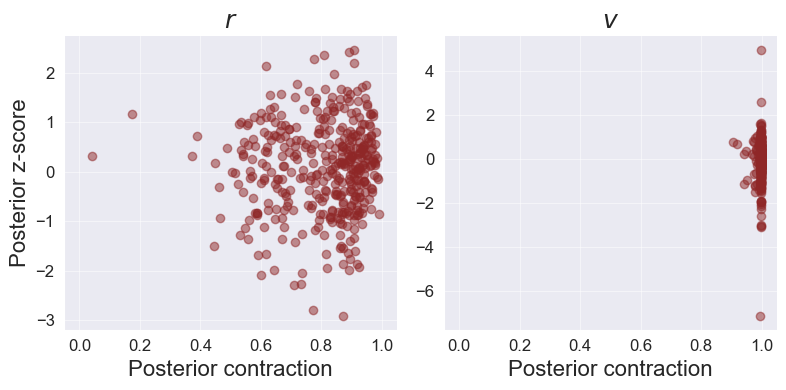

In [39]:
c = bf.diagnostics.plot_z_score_contraction(post_samples=post_samples, prior_samples=prior_samples, param_names=param_names)

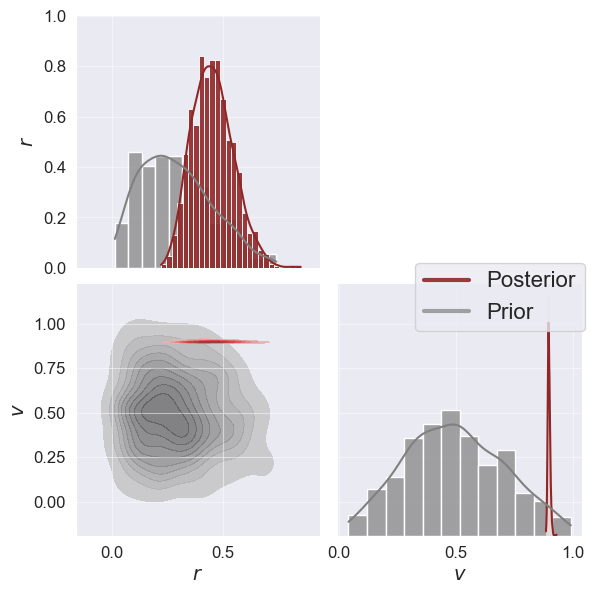

In [40]:
d = bf.diagnostics.plot_posterior_2d(posterior_draws=post_samples[1], prior_draws=prior_samples, param_names=param_names)